# Do some imports

In [399]:
from typing import List
import numpy as np
import pandas as pd
#!pip install --user pandas

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math

from dataloader import UNSW_NB15

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option("display.precision",30)

from decimal import *
getcontext().prec = 20
import math

### Inspired by [this github file](https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb)

# Get UNSW_NB15 train and test set

In [ ]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv

In [ ]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

# Define the Neural Network class

In [ ]:
# define NN architecture
class Net(nn.Module):
    
    def __init__(self, input_size,hidden1, hidden2, hidden3, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.batchnorm1 = nn.BatchNorm1d(hidden1)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.batchnorm2 = nn.BatchNorm1d(hidden2)
        self.relu2 = nn.ReLU()

        
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.batchnorm3 = nn.BatchNorm1d(hidden3)
        self.relu3 = nn.ReLU()

        
        self.out = nn.Linear(hidden3, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        a1 = self.fc1(x)
        #b1 = self.batchnorm1(a1)
        h1 = self.relu1(a1)
        dout1 = self.dout(h1)
        
        a2 = self.fc2(dout1)
        #b2 = self.batchnorm2(a2)
        h2 = self.relu2(a2)
        dout2 = self.dout(h2)
        
        a3 = self.fc3(dout2)
        #b3 = self.batchnorm3(a3)
        h3 = self.relu3(a3)
        dout3 = self.dout(h3)
        
        a4= self.out(dout3)
        y = self.sigmoid(a4)
        return y

### Define Train,   Test   and    Display_Loss_Plot    methods

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    y_true = []
    y_pred = []
    
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, target ( or labels)]
        inputs , target = data
        
        optimizer.zero_grad()
        
        #MOVING THE TENSORS TO THE CONFIGURED DEVICE
        #inputs, target = inputs.to(device), target.to(device)
        
        #FORWARD PASS
        output = model(inputs.float())

        loss = criterion(output, target.unsqueeze(1))
        #import pdb; pdb.set_trace()
        
        #BACKWARD AND OPTIMIZE
        
        loss.backward()
        optimizer.step()
        
        # PREDICTIONS
        #pred = np.round(output.detach().numpy())
        pred = output.detach().numpy() > 0.5  
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        
        losses.append(loss.data.numpy()) 
    #print("Accuracy on training set is" , accuracy_score(y_true,y_pred))
    return losses

In [ ]:
#TESTING THE MODEL
def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for data in test_loader:
            
            #LOAD THE DATA IN A BATCH
            inputs ,target = data
            
            # the model on the data
            output = model(inputs.float())
                       
            #PREDICTIONS
            pred = np.round(output)
            #pred = output.detach().numpy() > 0.5 
            pred = pred * 1
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [ ]:
def display_loss_plot(losses):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title('Loss of the model')
    plt.xlabel('iterations')
    plt.ylabel('Cross entropy loss')
    plt.show()

# Define some parameters first

In [ ]:
device = 'cpu'
input_size = 196      # 42 for integer encoding 196
hidden1 = 128      # 1st layer number of neurons
hidden2 = 64
hidden3 = 32
num_classes = 1    # binary classification

num_epochs = 1000  #500 1000 100 100
batch_size = 500   #100 1000 100 500  
lr = 0.01          #0.01 0.01 0.005 0.1

# Initialize Neural Network class

In [ ]:
model = Net(input_size, hidden1, hidden2, hidden3, num_classes)

# Define loss and optimizer 

In [ ]:
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Initialize UNSW_NB15 class

In [ ]:
#these are not slitted into validation and train set
train_dataset = UNSW_NB15(file_path ='UNSW_NB15_training-set.csv')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#get the test dataframe
test_dataset = UNSW_NB15(file_path ='UNSW_NB15_testing-set.csv')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Lets Train, Test the model and see the loss

In [ ]:
running_loss = []
for epoch in tqdm(range(num_epochs)):
        loss_epoch = train(model, device, train_loader, optimizer,criterion)
        running_loss.append(loss_epoch)

In [ ]:
test(model,device,test_loader)

In [ ]:
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

**********************************************************************************************************************

# Results

    num_epochs = 200
    batch_size = 8000 
    lr = 0.001
    accuracy on test set = 0.7572389836272653
<img src="data/loss_function_75.723898_acc.PNG">

# Quntization


In [30]:
from sklearn import preprocessing
def integer_encoding(df_):
    df = df_.copy()
    """Applies integer encoding to the object columns of the dataframe"""
    le = preprocessing.LabelEncoder()
    
    for column in df.select_dtypes('object').columns.tolist():
        df[column] = le.fit_transform(df[column])
    return df

In [31]:
# adapted from here https://stackoverflow.com/questions/51471097/vectorized-conversion-of-decimal-integer-array-to-binary-array-in-numpy
def dec2bin(column: pd.Series, number_of_bits: int, left_msb:bool= True )-> pd.Series: 
    """Convert a decimal pd.Series to binary pd.Series with numbers in their base-2 equivalents.
    The output is a numpy nd array.   
    # adapted from here https://stackoverflow.com/questions/51471097/vectorized-conversion-of-decimal-integer-array-to-binary-array-in-numpy

    Parameters
    ----------
     column: pd.Series
        Series wit all decimal numbers that will be cast to binary
     number_of_bits: str
        The desired number of bits for the binary number. If bigger than what is needed then those bits will be 0.
        The number_of_bits should be >= than what is needed to express the largest decimal input 
     left_msb: bool
        Specify that the most significant digit is the leftmost element. If this is False, it will be the rightmost element.
    Returns
    -------
    numpy.ndarray
       Numpy array with all elements in binary representation of the input.
        
    """
 
    my_binary_repr = lambda number, nbits:  np.binary_repr(number, nbits)[::-1]
    func = my_binary_repr if left_msb else np.binary_repr
 
    return np.vectorize(func)(column.values, number_of_bits)

# Get dataset and preprocess

In [360]:
train = pd.read_csv('data/UNSW_NB15_training-set.csv', sep = ",")
test = pd.read_csv('data/UNSW_NB15_testing-set.csv', sep = ",")

df = pd.concat([test,train],ignore_index=True)
skip_cols = ['id','attack_cat'] #this is what they have
binary_matrix = None # final matrix of bit vetors
first_iteration = True

# gets the smallest positive number of a vector
get_min_positive_number = lambda vector: vector[vector > 0].min()
# computes the maximum required bits to represent eachs number from a vector of numbers
get_max_bits = lambda vector: math.ceil(math.log2(vector.max()+1))

df = integer_encoding(df) #perform integer encoding on the string columns just as they do
total_bits = 0
for idx, column in enumerate(df.columns):
    if column not in skip_cols:
        m = get_min_positive_number(df[column])
        m = np.float64(1/m)
       
        if m>1:
            df[column] = df[column] * m
            print('column=', column , "m=",m)
        maxbits = get_max_bits(df[column])
        total_bits += maxbits
        #print(str(idx), " : ", str(total_bits))
        binary_vector = dec2bin(df[column].astype(np.uint32), maxbits, left_msb=False).reshape((-1,1))
        if first_iteration:
            binary_matrix = binary_vector
            first_iteration = False
        else:
            binary_matrix = np.hstack([binary_matrix, binary_vector])

id_= round((2*binary_matrix.shape[0])/3)
id6 = round((2*binary_matrix.shape[0])/3/6)

infeat_train = binary_matrix[0:id_-id6,:]
infeat_valid = binary_matrix[(id_-id6+1):id_,:]
infeat_test  = binary_matrix[id_+1:,:]

infeat_train = infeat_train[0:round(infeat_train.shape[0]/10),:];
infeat_valid = infeat_valid[0:round(infeat_valid.shape[0]/10),:];
infeat_test  = infeat_test[0:round(infeat_test.shape[0]/10),:]

np.savetxt("fds_unswb15_train_python.csv", infeat_train, fmt="%s",delimiter="")
np.savetxt('fds_unswb15_valid_python.csv', infeat_valid, fmt="%s",delimiter="")
np.savetxt('fds_unswb15_test_python.csv', infeat_test, fmt="%s",delimiter="")

column= dur m= 1000000.0
column= rate m= 678.4260515603798
column= sload m= 1.843668014387985
column= sinpkt m= 1000.0
column= dinpkt m= 1000.0
column= sjit m= 1000.0
column= djit m= 100.0
column= tcprtt m= 2197.802197802198
column= synack m= 2457.002457002457
column= ackdat m= 14492.753623188406


# Test everything

In [400]:
train = pd.read_csv('data/UNSW_NB15_training-set.csv', sep = ",")
test = pd.read_csv('data/UNSW_NB15_testing-set.csv', sep = ",")

df = pd.concat([test,train])
skip_cols = ['id','attack_cat'] #this is what they have
df.head(2)

id                               dur proto service state  spkts  dpkts  \
0   1  0.000010999999999999999713987467   udp       -   INT      2      0   
1   2  0.000007999999999999999637984895   udp       -   INT      2      0   

   sbytes  dbytes                                   rate  sttl  dttl  \
0     496       0   90909.090200000006007030606269836426   254     0   
1    1762       0  125000.000299999999697320163249969482   254     0   

         sload  dload  sloss  dloss                            sinpkt  dinpkt  \
0  180363632.0    0.0      0      0  0.011000000000000001096345236817     0.0   
1  881000000.0    0.0      0      0  0.008000000000000000166533453694     0.0   

   sjit  djit  swin  stcpb  dtcpb  dwin  tcprtt  synack  ackdat  smean  dmean  \
0   0.0   0.0     0      0      0     0     0.0     0.0     0.0    248      0   
1   0.0   0.0     0      0      0     0     0.0     0.0     0.0    881      0   

   trans_depth  response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  \
0            0                  0           2             2           1   
1            0                  0           2             2           1   

   ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0                 1                 1               2             0   
1                 1                 1               2             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2                0   
1           0                 0           1           2                0   

  attack_cat  label  
0     Normal      0  
1     Normal      0

In [401]:
df_encoded = integer_encoding(df)
df_encoded.head(6)

id                               dur  proto  service  state  spkts  dpkts  \
0   1  0.000010999999999999999713987467    119        0      5      2      0   
1   2  0.000007999999999999999637984895    119        0      5      2      0   
2   3  0.000005000000000000000409015270    119        0      5      2      0   
3   4  0.000006000000000000000152005145    119        0      5      2      0   
4   5  0.000010000000000000000818030539    119        0      5      2      0   
5   6  0.000003000000000000000076002572    119        0      5      2      0   

   sbytes  dbytes                                   rate  sttl  dttl  \
0     496       0   90909.090200000006007030606269836426   254     0   
1    1762       0  125000.000299999999697320163249969482   254     0   
2    1068       0  200000.005100000009406358003616333008   254     0   
3     900       0  166666.660800000012386590242385864258   254     0   
4    2126       0  100000.002500000002328306436538696289   254     0   
5     784       0  333333.321500000020023435354232788086   254     0   

          sload  dload  sloss  dloss                            sinpkt  \
0   180363632.0    0.0      0      0  0.011000000000000001096345236817   
1   881000000.0    0.0      0      0  0.008000000000000000166533453694   
2   854400000.0    0.0      0      0  0.005000000000000000104083408559   
3   600000000.0    0.0      0      0  0.006000000000000000124900090270   
4   850400000.0    0.0      0      0  0.010000000000000000208166817117   
5  1045333312.0    0.0      0      0  0.003000000000000000062450045135   

   dinpkt  sjit  djit  swin  stcpb  dtcpb  dwin  tcprtt  synack  ackdat  \
0     0.0   0.0   0.0     0      0      0     0     0.0     0.0     0.0   
1     0.0   0.0   0.0     0      0      0     0     0.0     0.0     0.0   
2     0.0   0.0   0.0     0      0      0     0     0.0     0.0     0.0   
3     0.0   0.0   0.0     0      0      0     0     0.0     0.0     0.0   
4     0.0   0.0   0.0     0      0      0     0     0.0     0.0     0.0   
5     0.0   0.0   0.0     0      0      0     0     0.0     0.0     0.0   

   smean  dmean  trans_depth  response_body_len  ct_srv_src  ct_state_ttl  \
0    248      0            0                  0           2             2   
1    881      0            0                  0           2             2   
2    534      0            0                  0           3             2   
3    450      0            0                  0           3             2   
4   1063      0            0                  0           3             2   
5    392      0            0                  0           2             2   

   ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
0           1                 1                 1               2   
1           1                 1                 1               2   
2           1                 1                 1               3   
3           2                 2                 1               3   
4           2                 2                 1               3   
5           2                 2                 1               2   

   is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  \
0             0           0                 0           1           2   
1             0           0                 0           1           2   
2             0           0                 0           1           3   
3             0           0                 0           2           3   
4             0           0                 0           2           3   
5             0           0                 0           2           2   

   is_sm_ips_ports  attack_cat  label  
0                0           6      0  
1                0           6      0  
2                0           6      0  
3                0           6      0  
4                0           6      0  
5                0           6      0

In [402]:
np.int64(2.1 +0.5)

2

In [407]:
# gets the smallest positive number of a vector
get_min_positive_number = lambda vector: vector[vector > 0].min()
# computes the maximum required bits to represent eachs number from a vector of numbers
get_max_bits = lambda vector: math.ceil(math.log2(float(vector.max())+1.0))

binarized_dataset = pd.DataFrame(columns= df_encoded.columns) # final matrix of bit vetors
first_iteration = True

binarized_dataset = df_encoded.copy()\
                                .drop(columns=skip_cols)
total_bits = 0
column_bit_position = []
tmp_df = pd.DataFrame()
for column in binarized_dataset.columns:
        
    column_data = df_encoded[column]
    
    m = get_min_positive_number(column_data)
    m_inv = np.float64(1/m)
    
    if m_inv>1:
        column_data = column_data * np.float64(m_inv)
        
    #column_data = column_data.round(13)
    column_data = column_data + 0.5000
    if(column == "rate"):
        print("----------------bofore numpy float64",column_data.iloc[712:719])
    column_data = column_data.astype(np.uint64)
    if(column == "rate"):
        print("-----------after unmpy float64",column_data.iloc[712:719])
    tmp_df[column] = pd.Series(column_data).astype(np.float64)
    #tmp_df[column] = tmp_df[column].astype(np.int64 + 0.5)
    maxbits = get_max_bits(column_data)
    print('column=',column, " m=", m, " m_inv=",m_inv, " b=",maxbits) 
    total_bits += maxbits
    column_bit_position.append([column, total_bits])
    #print(column, " : ", total_bits)
    binary_vector = dec2bin(column_data, maxbits, left_msb=False).reshape((-1,1))
    binarized_dataset[column] = binary_vector.flatten()
    

#Merge the columns
binarized_dataset_concated = binarized_dataset.apply(lambda row: "".join(row),axis=1).values.reshape((-1,1))
binarized_dataset_concated.shape


column= dur  m= 1e-06  m_inv= 1000000.0  b= 26
column= proto  m= 1  m_inv= 1.0  b= 8
column= service  m= 1  m_inv= 1.0  b= 4
column= state  m= 1  m_inv= 1.0  b= 4
column= spkts  m= 1  m_inv= 1.0  b= 14
column= dpkts  m= 1  m_inv= 1.0  b= 14
column= sbytes  m= 24  m_inv= 0.041666666666666664  b= 24
column= dbytes  m= 28  m_inv= 0.03571428571428571  b= 24
----------------bofore numpy float64 712    8.480325714857529103755950927734e+07
713    7.513396472184531739912927150726e+04
714    8.480325714857529103755950927734e+07
715    3.471599999999999272404238581657e+04
716    4.066364993215739104925887659192e+03
717    1.356852142720488309860229492188e+08
718    3.065190909090908826328814029694e+04
Name: rate, dtype: float64
-----------after unmpy float64 712     84803257
713        75133
714     84803257
715        34715
716         4066
717    135685214
718        30651
Name: rate, dtype: uint64
column= rate  m= 0.001474  m_inv= 678.4260515603798  b= 30
column= sttl  m= 1  m_inv= 1.0  b= 8


(257673, 1)

In [382]:
tmp_df.iloc[715:716,:]

dur  proto  service  state  spkts  dpkts  sbytes  dbytes     rate  \
715  644901.0  113.0      9.0    4.0   18.0   16.0  2716.0  1106.0  34715.0   

      sttl   dttl    sload    dload  sloss  dloss   sinpkt   dinpkt  \
715  254.0  252.0  58686.0  12864.0    6.0    6.0  36945.0  41990.0   

          sjit    djit   swin         stcpb         dtcpb   dwin  tcprtt  \
715  1887531.0  4867.0  255.0  2562552489.0  1202459092.0  255.0    72.0   

     synack  ackdat  smean  dmean  trans_depth  response_body_len  ct_srv_src  \
715    37.0   256.0  151.0   69.0          0.0                0.0         1.0   

     ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  \
715           1.0         1.0               1.0               1.0   

     ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  \
715             1.0           0.0         0.0               0.0         1.0   

     ct_srv_dst  is_sm_ips_ports  label  
715         1.0              0.0    1.0

# Check the differences between the binary (quantized datasets)

#### Get the matlab quantized dataset

In [332]:
binfeat = pd.read_csv('binfeat_1.csv',header=None).values
print(binfeat.shape)
#binfeat[0]

(257673, 1)


In [345]:
df_binfeat_decimal = sep_array_several_columns(binfeat[0:1000], column_bit_position)
df_binfeat_decimal = df_binfeat_decimal[['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label']]
df_binfeat_decimal=df_binfeat_decimal.astype(np.int64)
df_binfeat_decimal.head()

dur  proto  service  state  spkts  dpkts  sbytes  dbytes       rate  sttl  \
0   11    119        0      5      2      0     496       0   61675095   254   
1    8    119        0      5      2      0    1762       0   84803257   254   
2    5    119        0      5      2      0    1068       0  135685214   254   
3    6    119        0      5      2      0     900       0  113071005   254   
4   10    119        0      5      2      0    2126       0   67842607   254   

   dttl       sload  dload  sloss  dloss  sinpkt  dinpkt  sjit  djit  swin  \
0     0   332530659      0      0      0      11       0     0     0     0   
1     0  1624271521      0      0      0       8       0     0     0     0   
2     0  1575229951      0      0      0       5       0     0     0     0   
3     0  1106200809      0      0      0       6       0     0     0     0   
4     0  1567855279      0      0      0      10       0     0     0     0   

   stcpb  dtcpb  dwin  tcprtt  synack  ackdat  smean  dmean  trans_depth  \
0      0      0     0       0       0       0    248      0            0   
1      0      0     0       0       0       0    881      0            0   
2      0      0     0       0       0       0    534      0            0   
3      0      0     0       0       0       0    450      0            0   
4      0      0     0       0       0       0   1063      0            0   

   response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  \
0                  0           2             2           1                 1   
1                  0           2             2           1                 1   
2                  0           3             2           1                 1   
3                  0           3             2           2                 2   
4                  0           3             2           2                 2   

   ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0                 1               2             0           0   
1                 1               2             0           0   
2                 1               3             0           0   
3                 1               3             0           0   
4                 1               3             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  label  
0                 0           1           2                0      0  
1                 0           1           2                0      0  
2                 0           1           3                0      0  
3                 0           2           3                0      0  
4                 0           2           3                0      0

In [333]:
def get_list_output_sep_list(list_:list,index_values:list):
    #assert len(list_[0]) == 594, f"Each element of the list has has the wrong size len(a)={len(a)}, len(b)={len(b)}"
    tmp_list= []
    for current_i in index_values:   
        print()
        if current_i != 26:
            tmp_list.append(list_[0][previous_i:current_i])
        else:          
            tmp_list.append(list_[0][0:current_i])
        previous_i=current_i
    return tmp_list
index_values = [el[1] for el in column_bit_position]
#get_list_output_sep_list(["000000000000000000000010110111011100000101000000000000100000000000000000000000000000011111000000000000000000000000000000001110101101000101100101011111111110000000000000010011110100100000001111100011000000000000000000000000000000000000000000000000000000000000000000000000001011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000001001000000100000100000100000100000000000000000100001000"],index_values)

In [334]:
def sep_array_several_columns(array:np.ndarray, column_bit_position:list):
    #receives a list of binary rows, all values of each row are concatenated together. THis method separates them,
    #transofrms them to datframe and then converts to decimal
    index=['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label']
    df_decimal=pd.DataFrame()
    index_values = [el[1] for el in column_bit_position]
    for ix in range(array.shape[0]):
        row_list = []
        series = pd.Series(get_list_output_sep_list(array[ix],index_values), index=index)
        df_decimal = df_decimal.append(series, ignore_index=True)
        
    for column in df_bin.columns:
        df_decimal[column] = df_decimal[column].astype(str).apply(lambda x: format(int(x,2)))
    return df_decimal

#df_binfeat_decimal = sep_array_several_columns(binfeat[0:4], column_bit_position)

##### Lets check for the differences

In [408]:
# The number of correct columns is 22 683 out of 257 673 total
(binfeat == binarized_dataset_concated).sum()

257328

In [225]:
#this outputs the bit position(s) that is different between each row
check_diff(binarized_dataset_concated[1][0], binfeat[1][0])

[]

In [337]:
def bar_plot(dictionary: dict, x_label, y_label, title):
    fig = plt.figure(figsize = (10, 5)) 

    plt.bar(list(dictionary.keys()),  list(dictionary.values()) ) 

    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.title(title) 
    plt.show() 
    
def check_diff(a : str, b : str) -> List[int]:
    """
    return the positions where a != b
    """
    result = []
    assert len(a) == len(b), f"the two strings must have equal size. len(a)={len(a)}, len(b)={len(b)}"
    
    for i in range(len(a)):
        if a[i] != b[i]:
            result.append(i)
    return result

def multi_check_diff(A,B):
    assert A.shape == B.shape, f"Both matrices must match in shape. A shape is {A.shape}, B shape is {B.shape}"
    
    all_diffs = []
    for i in range(A.shape[0]):
        all_diffs.append(check_diff(A[i][0], B[i][0]))
    return all_diffs

all_diffs = multi_check_diff(binfeat, binarized_dataset_concated)

In [338]:
def belongs_to_column(num : int, col_positions : List[List]):
    """
    given any index position, returns the column that contains the bit of that position.
    """
    for i in range(len(col_positions)):
        if num < col_positions[i][1]:
            return col_positions[i]

# test -> should return rate, 148
assert belongs_to_column(147, column_bit_position) == ['rate', 148], "Function is failing"

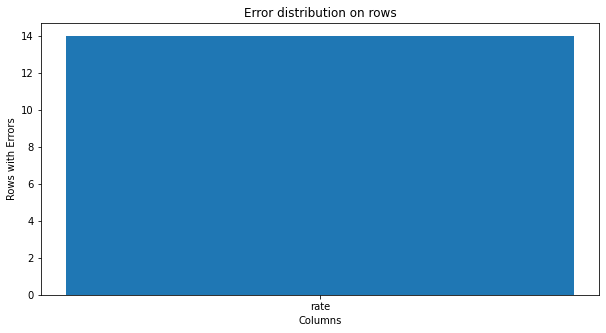

In [339]:
def error_row_column_distribution(all_diffs : List[List], col_positions : List[List]):
    """
    For each row, counts the errors of each column. 
    One or more errors per row for the same column are counted as just +1
    """
    count_dictionary = {} # key -> bit position starting from last ; value -> count of errors in this position
    for diffs in all_diffs:
        row_column_errors = []
        for diff in diffs:
            column, last_pos = belongs_to_column(diff, col_positions)
            if column in row_column_errors:
                continue
            row_column_errors.append(column)
            
            if column not in count_dictionary:
                count_dictionary[column] = 1
            else:
                count_dictionary[column] += 1
    
    sorted_count = {k:v for k,v in sorted(count_dictionary.items(), key = lambda item: item[1])}
    return sorted_count
sorted_count = error_row_column_distribution(all_diffs, column_bit_position)

bar_plot( sorted_count, x_label="Columns", y_label="Rows with Errors", title="Error distribution on rows")

    	"rate column has 147k rows that are wrong with at least 1 errors in each of the rows"
        "The only columns that have bit errors are: rate, sload, sinpkt, ackdat, sjit,dload,djit,dinpkt,tcprtt,synack, dur"

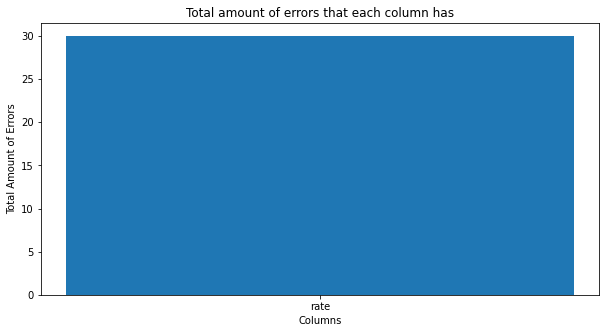

In [340]:
def error_bit_column_distribution(all_diffs : List[List], col_positions : List[List]):
    count_dictionary = {} # key -> bit position starting from last ; value -> count of errors in this position
    for diffs in all_diffs:
        for diff in diffs:
            column, last_pos = belongs_to_column(diff, col_positions)
            
            if column not in count_dictionary:
                count_dictionary[column] = 1
            else:
                count_dictionary[column] += 1
    
    sorted_count = {k:v for k,v in sorted(count_dictionary.items(), key = lambda item: item[1])}
    
    return sorted_count

sorted_count = error_bit_column_distribution(all_diffs, column_bit_position)

bar_plot( sorted_count, x_label="Columns", y_label="Total Amount of Errors", title="Total amount of errors that each column has") 

    sload column has a total of 332k errors
    rate column has a total of 261k errors
    sinpkt column has a total of 132k errors

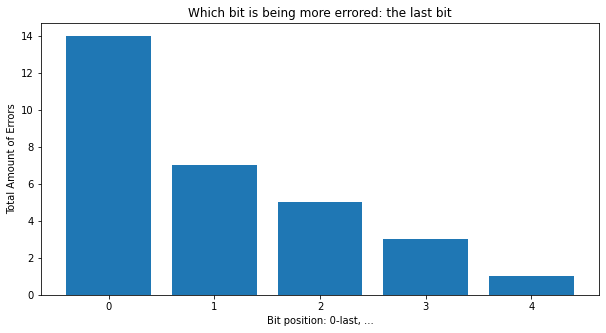

In [341]:
def error_bit_position_distribution(all_diffs : List[List], col_positions : List[List]):
    count_dictionary = {} # key -> bit position starting from last ; value -> count of errors in this position
    for diffs in all_diffs:
        for diff in diffs:
            column, last_pos = belongs_to_column(diff, col_positions)
            position_counting_from_last = last_pos - diff - 1
            
            if position_counting_from_last not in count_dictionary:
                count_dictionary[position_counting_from_last] = 1
            else:
                count_dictionary[position_counting_from_last] += 1
    
    sorted_count = {k:v for k,v in sorted(count_dictionary.items(), key = lambda item: item[1])}
    return sorted_count
sorted_count = error_bit_position_distribution(all_diffs, column_bit_position)
bar_plot( sorted_count, x_label="Bit position: 0-last, ...", y_label="Total Amount of Errors", title="Which bit is being more errored: the last bit") 

    791k of all the errors that are made, are in the last bit
    420k of the errors are on the second to last bit
    179k of the errors are on the third to last bit
    this suggests floating point precision not enough .. ?

# Check the differences between the decimal (not quantized) dataset

#### Get the matlab decimal dataset

In [22]:
pd.set_option("display.precision",40)
#pd.option_context('display.precision', 40)
decimal_binfeat = pd.read_csv('decimal_binfeat.csv',sep = " ",header=None, float_precision = 'round_trip')
decimal_binfeat = decimal_binfeat.drop(columns = [0,43])
decimal_binfeat.columns = tmp_df.columns.tolist()
print(decimal_binfeat.shape)
decimal_binfeat.head(20)

(257673, 43)


dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
0   11.0  119.0      0.0    5.0    2.0    0.0   496.0     0.0   
1    8.0  119.0      0.0    5.0    2.0    0.0  1762.0     0.0   
2    5.0  119.0      0.0    5.0    2.0    0.0  1068.0     0.0   
3    6.0  119.0      0.0    5.0    2.0    0.0   900.0     0.0   
4   10.0  119.0      0.0    5.0    2.0    0.0  2126.0     0.0   
5    3.0  119.0      0.0    5.0    2.0    0.0   784.0     0.0   
6    6.0  119.0      0.0    5.0    2.0    0.0  1960.0     0.0   
7   28.0  119.0      0.0    5.0    2.0    0.0  1384.0     0.0   
8    0.0    6.0      0.0    5.0    1.0    0.0    46.0     0.0   
9    0.0    6.0      0.0    5.0    1.0    0.0    46.0     0.0   
10   0.0    6.0      0.0    5.0    1.0    0.0    46.0     0.0   
11   0.0    6.0      0.0    5.0    1.0    0.0    46.0     0.0   
12   4.0  119.0      0.0    5.0    2.0    0.0  1454.0     0.0   
13   7.0  119.0      0.0    5.0    2.0    0.0  2062.0     0.0   
14  11.0  119.0      0.0    5.0    2.0    0.0  2040.0     0.0   
15   4.0  119.0      0.0    5.0    2.0    0.0  1052.0     0.0   
16   3.0  119.0      0.0    5.0    2.0    0.0   314.0     0.0   
17  10.0  119.0      0.0    5.0    2.0    0.0  1774.0     0.0   
18   2.0  119.0      0.0    5.0    2.0    0.0  1568.0     0.0   
19   4.0  119.0      0.0    5.0    2.0    0.0  2054.0     0.0   

                                      rate   sttl  dttl  \
0    61675095.1153324246406555175781250000  254.0   0.0   
1    84803256.6485752910375595092773437500  254.0   0.0   
2   135685213.7720488309860229492187500000  254.0   0.0   
3   113071004.6132971495389938354492187500  254.0   0.0   
4    67842606.8521031141281127929687500000  254.0   0.0   
5   226142009.1587516963481903076171875000  254.0   0.0   
6   113071004.6132971495389938354492187500  254.0   0.0   
7    24229501.5061058290302753448486328125  254.0   0.0   
8           0.0000000000000000000000000000    0.0   0.0   
9           0.0000000000000000000000000000    0.0   0.0   
10          0.0000000000000000000000000000    0.0   0.0   
11          0.0000000000000000000000000000    0.0   0.0   
12  169606513.2971505820751190185546875000  254.0   0.0   
13   96918006.0379918515682220458984375000  254.0   0.0   
14   61675095.1153324246406555175781250000  254.0   0.0   
15  169606513.2971505820751190185546875000  254.0   0.0   
16  226142009.1587516963481903076171875000  254.0   0.0   
17   67842606.8521031141281127929687500000  254.0   0.0   
18  339213026.6621437668800354003906250000  254.0   0.0   
19  169606513.2971505820751190185546875000  254.0   0.0   

                                  sload  dload  sloss  dloss      sinpkt  \
0    332530659.277245223522186279296875    0.0    0.0    0.0        11.0   
1   1624271520.675814867019653320312500    0.0    0.0    0.0         8.0   
2   1575229951.493094444274902343750000    0.0    0.0    0.0         5.0   
3   1106200808.632791042327880859375000    0.0    0.0    0.0         6.0   
4   1567855279.435542583465576171875000    0.0    0.0    0.0        10.0   
5   1927247591.708656072616577148437500    0.0    0.0    0.0         3.0   
6   2409059460.137132167816162109375000    0.0    0.0    0.0         6.0   
7    364519508.773094236850738525390625    0.0    0.0    0.0        28.0   
8            0.000000000000000000000000    0.0    0.0    0.0  60000688.0   
9            0.000000000000000000000000    0.0    0.0    0.0  60000712.0   
10           0.000000000000000000000000    0.0    0.0    0.0  60000688.0   
11           0.000000000000000000000000    0.0    0.0    0.0  60000712.0   
12  2680693292.920130252838134765625000    0.0    0.0    0.0         4.0   
13  2172367649.526084899902343750000000    0.0    0.0    0.0         7.0   
14  1367666443.582836866378784179687500    0.0    0.0    0.0        11.0   
15  1939538751.136160373687744140625000    0.0    0.0    0.0         4.0   
16   771882322.357977628707885742187500    0.0    0.0    0.0         3.0   
17  1308266823.0097141265869140

#### Get the pyhton decimal dataset

In [26]:
print(tmp_df.shape)
tmp_df.head(2)

(257673, 43)


dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
0  11.0    119        0      5      2      0     496       0   
1   8.0    119        0      5      2      0    1762       0   

                                  rate  sttl  dttl  \
0  61675095.11533242464065551757812500   254     0   
1  84803256.64857529103755950927734375   254     0   

                                 sload  dload  sloss  dloss  \
0   332530659.277245223522186279296875    0.0      0      0   
1  1624271520.675814867019653320312500    0.0      0      0   

                                        sinpkt  dinpkt  sjit  djit  swin  \
0  11.0000000000000017763568394002504646778107     0.0   0.0   0.0     0   
1   8.0000000000000000000000000000000000000000     0.0   0.0   0.0     0   

   stcpb  dtcpb  dwin  tcprtt  synack  ackdat  smean  dmean  trans_depth  \
0      0      0     0     0.0     0.0     0.0    248      0            0   
1      0      0     0     0.0     0.0     0.0    881      0            0   

   response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  \
0                  0           2             2           1                 1   
1                  0           2             2           1                 1   

   ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0                 1               2             0           0   
1                 1               2             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  label  
0                 0           1           2                0      0  
1                 0           1           2                0      0

## Are they equal? 
    No

In [27]:
decimal_binfeat.equals(tmp_df)

False

## Where are the differences? 
    Floating point precision. 

In [346]:
def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('Pyhton', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

def get_highlight_diff(df1,df2):
    df_all = pd.concat([df1, df2], 
                       axis='columns', keys=['Pyhton', 'Matlab'])
    df_final = df_all.swaplevel(axis='columns')[df1.columns[1:]]
    return df_final.style.apply(highlight_diff, axis=None)

get_highlight_diff(tmp_df.reset_index(drop=True).loc[500:1000,:],df_binfeat_decimal.reset_index(drop=True).loc[500:1000,:])

In [380]:
tmp_df.iloc[715:716,:]

dur  proto  service  state  spkts  dpkts  sbytes  dbytes   rate  sttl  \
715  644901    113        9      4     18     16    2716    1106  34715   254   

     dttl  sload  dload  sloss  dloss  sinpkt  dinpkt     sjit  djit  swin  \
715   252  58686  12864      6      6   36945   41990  1887531  4867   255   

          stcpb       dtcpb  dwin  tcprtt  synack  ackdat  smean  dmean  \
715  2562552489  1202459092   255      72      37     256    151     69   

     trans_depth  response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  \
715            0                  0           1             1           1   

     ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
715                 1                 1               1             0   

     ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
715           0                 0           1           1                0   

     label  
715      1

In [379]:
df_encoded.iloc[715:716,:]

id       dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
715  716  0.644901    113        9      4     18     16    2716    1106   

          rate  sttl  dttl                 sload                 dload  sloss  \
715  51.170647   254   252  31831.24413999999888  12863.99022999999943      6   

     dloss     sinpkt     dinpkt                 sjit       djit  swin  \
715      6  36.945471  41.989668  1887.53104600000006  48.669301   255   

          stcpb       dtcpb  dwin    tcprtt    synack    ackdat  smean  dmean  \
715  2562552489  1202459092   255  0.032706  0.015047  0.017659    151     69   

     trans_depth  response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  \
715            0                  0           1             1           1   

     ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
715                 1                 1               1             0   

     ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
715           0                 0           1           1                0   

     attack_cat  label  
715           3      1

column= rate  m= 0.001474  m_inv= 678.4260515603798  b= 30